In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Keras uses TensforFlow backend as default
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Concatenate
from keras.layers import Conv1D,UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

In [28]:
import tensorflow as tf

import keras
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
import keras.layers as layer
from keras import backend as K

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1,28*28).astype('float32') / 255.
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.


In [30]:
oh_encoder = OneHotEncoder(categories='auto', sparse=False)
y_train_oh = oh_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh = oh_encoder.transform(y_test.reshape(-1, 1))


In [34]:
x_train_  = np.expand_dims(x_train, 1)
y_train_oh  = np.expand_dims(y_train_oh, 1)

In [35]:
x_test_  = np.expand_dims(x_test, 1)
y_test_oh  = np.expand_dims(y_test_oh, 1)

In [36]:
x_train_.shape, y_train_oh.shape,x_test_.shape, y_test_oh.shape

((60000, 1, 784), (60000, 1, 10), (10000, 1, 784), (10000, 1, 10))

In [67]:
h_size = 10
z_dims = 2
n_classes = 10
input_img =  keras.Input(shape=(1, 28*28))
input_cond = Input(shape=(1, n_classes))
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(z_dims, ))
    return mu + K.exp(log_var / 2) * eps



# Encoder
traj_input  =  Concatenate(axis=-1)([input_img, input_cond])
traj_input = layer.Conv1D(h_size, 3, activation = 'relu', padding = 'same')(traj_input)
traj_input = layer.MaxPool1D(4, padding = 'same')(traj_input)
traj_input = layer.Conv1D(1, 3, activation = 'relu', padding = 'same')(traj_input)
traj_input = layer.MaxPool1D(4, padding = 'same')(traj_input)
traj_input = layer.Flatten()(traj_input)

# Sampling

z_mean = layer.Dense(z_dims, activation='tanh')(traj_input)
z_var_log = layer.Dense(z_dims, activation='linear')(traj_input)
z = Lambda(sample_z, output_shape=(z_dims,))([z_mean, z_var_log])
z= layer.Reshape((1, z_dims))(z)
z_cond = Concatenate(axis=-1)([z, input_cond])

# Decoder
z_in = Input(shape=(1, z_dims,))
cond_in = Input(shape=(1, n_classes,))
dec_input = Concatenate(axis=-1)([z_in, cond_in])
z_traj_input = layer.Dense(50)(dec_input)
z_traj_input = layer.Reshape((25, 2))(z_traj_input)
z_traj_input = layer.Conv1D(h_size, 3, activation = 'relu', padding = 'same')(z_traj_input)
c = layer.UpSampling1D(2)(z_traj_input)
z_traj_input =   layer.UpSampling1D(2)(z_traj_input) #layer.Conv1D(2, 1, activation = 'relu', padding = 'same')(z_traj_input)
z_traj_input = layer.Flatten()(z_traj_input)
z_traj_input = layer.Dense(28*28, activation='sigmoid')(z_traj_input)
traj_hat = layer.Reshape((1, 28*28))(z_traj_input)

In [68]:
encoder = Model([input_img, input_cond], [z_mean, z_var_log, z, input_cond])
# encoder.summary()

In [69]:
decoder =  Model([z_in, cond_in], traj_hat)
# decoder.summary()

In [70]:
output= decoder(encoder([[input_img, input_cond]])[2:])

In [71]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [72]:
cvae = Model([input_img, input_cond], output)
cvae.compile(optimizer='adam', loss=loss_func(z_mean, z_var_log), metrics=['accuracy'])

In [73]:
cvae.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 1, 784)]     0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 1, 10)]      0           []                               
                                                                                                  
 model_10 (Functional)          [(None, 2),          23869       ['input_30[0][0]',               
                                 (None, 2),                       'input_31[0][0]']               
                                 (None, 1, 2),                                                    
                                 (None, 1, 10)]                                            

In [74]:
# train
cvae.fit([x_train_, y_train_oh], x_train_ ,
       shuffle=True,
       epochs=10,
       batch_size=64,
       verbose=1)

Epoch 1/10
938/938 [==============================] - 16s 16ms/step - loss: 59.3337 - accuracy: 0.0124
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 53.7612 - accuracy: 0.0142
Epoch 3/10
938/938 [==============================] - 15s 16ms/step - loss: 53.6629 - accuracy: 0.0144
Epoch 4/10
938/938 [==============================] - 15s 16ms/step - loss: 53.6285 - accuracy: 0.0147
Epoch 5/10
938/938 [==============================] - 17s 18ms/step - loss: 53.5883 - accuracy: 0.0141
Epoch 6/10
938/938 [==============================] - 15s 16ms/step - loss: 53.5711 - accuracy: 0.0146
Epoch 7/10
938/938 [==============================] - 14s 15ms/step - loss: 53.5529 - accuracy: 0.0143
Epoch 8/10
938/938 [==============================] - 14s 15ms/step - loss: 53.5395 - accuracy: 0.0143
Epoch 9/10
938/938 [==============================] - 15s 16ms/step - loss: 53.5280 - accuracy: 0.0145
Epoch 10/10
938/938 [==============================] - 15s 16ms/step - lo

In [91]:
num_class = 5
pred_class = np.array(oh_encoder.transform([[num_class]])).reshape(1,1,-1)
pred_noise = np.random.randn(1, z_dims).reshape(1,1,-1)
pred_out = decoder.predict([pred_noise, pred_class])

In [92]:
digit = pred_out.reshape(28, 28)

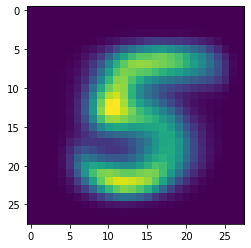

In [93]:
plt.imshow(digit)